# BrainUSL: Unsupervised Graph Structure Learning

This notebook implements the BrainUSL model from the paper *BrainUSL: Unsupervised Graph Structure Learning for Functional Brain Network Analysis*. It performs unsupervised graph structure learning on fMRI data for MDD/BD diagnosis.

## Step 1: Install and Import Dependencies
Install required packages:
```bash
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install numpy scikit-learn matplotlib
```
Import libraries and set up the device (GPU/CPU).

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity
import numpy as np
import random
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Set random seed for reproducibility
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(10)

Device: cuda


## Step 2: Define Utility Functions
These functions compute graph similarities, losses, and metrics:
- `corrcoef`: Computes correlation matrix for fMRI signals.
- `cos_similar`: Computes cosine similarity between node embeddings.
- `sameLoss`: View consistency loss.
- `unsupervisedGroupContrast`: Correlation-guided contrastive loss.
- `rbfKernel`, `kernelEntry`, `distMatrix`, `graph_similarity`: Graph kernel functions for similarity matrix.
- `confusion`: Computes accuracy, sensitivity, specificity, and AUC.

In [2]:
def corrcoef(data, replace_nan_as=0):
    x = data - torch.mean(data, dim=-1, keepdim=True)
    cov = x.matmul(x.transpose(-2, -1)) / (x.shape[-1] - 1)
    d = cov[:, range(cov.shape[1]), range(cov.shape[1])]
    stddev = torch.sqrt(d + 1e-8)  # Avoid zero division
    cov /= stddev[:, :, None]
    cov /= stddev[:, None, :]
    cov = torch.where(torch.isnan(cov), torch.full_like(cov, replace_nan_as), cov)
    return cov

def confusion(g_turth, predictions):
    tn, fp, fn, tp = confusion_matrix(g_turth, predictions).ravel()
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    sensitivity = (tp) / (tp + fn + 1e-8)
    specificity = (tn) / (tn + fp + 1e-8)
    auc = metrics.roc_auc_score(g_turth, predictions, average='macro')
    return accuracy, sensitivity, specificity, auc

def cos_similar(p, q):
    sim_matrix = p.matmul(q.transpose(-2, -1))
    a = torch.norm(p, p=2, dim=-1)
    b = torch.norm(q, p=2, dim=-1)
    sim_matrix /= (a.unsqueeze(-1) + 1e-8)
    sim_matrix /= (b.unsqueeze(-2) + 1e-8)
    sim_matrix = torch.where(torch.isnan(sim_matrix), torch.full_like(sim_matrix, 0), sim_matrix)
    return sim_matrix

def sameLoss(x, x_aug):
    x_abs = x.norm(dim=1)
    x_aug_abs = x_aug.norm(dim=1)
    loss = 2 - cosine_similarity(x, x_aug, dim=-1).mean() - cosine_similarity(x_abs, x_aug_abs, dim=-1).mean()
    return loss

def unsupervisedGroupContrast(x, x_aug, label, T=0.4):
    x_abs = x.norm(dim=1)
    x_aug_abs = x_aug.norm(dim=1)
    sim_matrix1 = torch.einsum('ik,jk->ij', x, x) / torch.einsum('i,j->ij', x_abs, x_abs)
    sim_matrix1 = torch.exp(sim_matrix1 / T)
    sim_matrix2 = torch.einsum('ik,jk->ij', x_aug, x_aug) / torch.einsum('i,j->ij', x_aug_abs, x_aug_abs)
    sim_matrix2 = torch.exp(sim_matrix2 / T)
    sim_matrix = torch.cat([sim_matrix1, sim_matrix2], dim=0)
    pos_label = label.tile(dims=[2, 1])
    neg_label = (1 - pos_label)
    pos = sim_matrix[pos_label.bool()].mean() + 1
    neg = sim_matrix[neg_label.bool()].sum() / (neg_label.sum() - neg_label.shape[0] + 1e-8) + 1
    loss = -torch.log(pos / neg)
    return loss

def rbfKernel(bag1, bag2, gamma):
    n, m = bag1.shape[0], bag2.shape[0]
    bag1_i_norm = torch.sum(bag1 ** 2, dim=1)
    bag2_i_norm = torch.sum(bag2 ** 2, dim=1)
    distMat = torch.tile(bag1_i_norm, [m, 1]).T + torch.tile(bag2_i_norm, [n, 1]) - 2 * bag1.matmul(bag2.T)
    kMat = torch.exp(-gamma * distMat)
    return kMat

def kernelEntry(bag1, bag2, weightMatrix1, weightMatrix2, gamma):
    n, m = bag1.shape[0], bag2.shape[0]
    activeEdgesCount1 = weightMatrix1.sum(dim=1)
    activeEdgesCount2 = weightMatrix2.sum(dim=1)
    activeEdgesCoef1 = 1. / (activeEdgesCount1 + 1e-3)
    activeEdgesCoef2 = 1. / (activeEdgesCount2 + 1e-3)
    k = rbfKernel(bag1, bag2, gamma=gamma)
    k = torch.tile(activeEdgesCoef1, dims=[m, 1]).T * torch.tile(activeEdgesCoef2, dims=[n, 1]) * k
    k = torch.sum(k) / torch.sqrt(torch.sum(activeEdgesCoef1)) / torch.sqrt(torch.sum(activeEdgesCoef2))
    return k

def distMatrix(bag, method='gaussian', gamma=1):
    n = bag.shape[0]
    bag_i_norm = torch.sum(bag ** 2, dim=1)
    distMat = torch.tile(bag_i_norm, [n, 1]) + torch.tile(bag_i_norm, [n, 1]).T - 2 * bag.matmul(bag.T)
    if method == 'gaussian':
        distMat = 1 - torch.exp(-gamma * distMat)
    return distMat

def graph_similarity(bag, method='gaussian', gamma=1):
    n = bag.shape[0]
    graph_kernel = torch.zeros(size=(n, n))
    w = torch.zeros_like(bag)
    for wi in range(n):
        w[wi] = distMatrix(bag[wi])
    for i in range(n):
        for j in range(i + 1, n):
            mat = kernelEntry(bag[i], bag[j], w[i], w[j], 0.5)
            graph_kernel[i][j] = mat
            graph_kernel[j][i] = mat
    return graph_kernel

## Step 3: Define Model Classes
- `SigCNN`: Graph generation module with 1D convolutions and learnable adjacency matrix (`w`) for sparse graphs.
- `E2E`: Topology-aware encoder with cross-shaped filters to capture edge-to-node information.
- `Model`: Combines `SigCNN`, `E2E`, and a linear classifier. Supports pre-training (unsupervised) and fine-tuning (supervised).

In [3]:
class SigCNN(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SigCNN, self).__init__()
        self.in_channel = in_channel
        self.conv1 = nn.Conv1d(in_channels=in_channel, out_channels=out_channel, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=out_channel, out_channels=out_channel, kernel_size=15)
        self.bn = nn.BatchNorm1d(116, affine=True)
        self.bn2 = nn.BatchNorm1d(116, affine=True)
        self.alpha = 1
        self.beta = 1
        self.w = nn.Parameter(torch.FloatTensor(116, 116), requires_grad=True)
        nn.init.uniform_(self.w, a=0, b=1)

    def _normalize(self, mx):
        rowsum = mx.sum(1)
        r_inv = rowsum.pow(-1 / 2).flatten()
        r_inv[torch.isinf(r_inv)] = 0.
        r_mat_inv = torch.diag(r_inv)
        mx = r_mat_inv @ mx
        mx = mx @ r_mat_inv
        return mx

    def get_w_data(self):
        w = self.grad_w()
        return w.data

    def grad_w(self):
        w = self._normalize(self.w)
        w = F.relu(self.bn2(w))
        w = (w + w.T) / 2
        return w

    def forward(self, x):
        x = self.bn(x)
        x = self.conv1(x)
        x = self.conv2(x).reshape(x.shape[0], self.in_channel, -1)
        x = cos_similar(x, x)
        w = self._normalize(self.w)
        w = F.relu(self.bn2(w))
        w = (w + w.T) / 2
        l1 = torch.norm(w, p=1, dim=1).mean()
        x = w * x
        return x, l1

class E2E(nn.Module):
    def __init__(self, in_channel, out_channel, input_shape):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.d = input_shape[0]
        self.conv1xd = nn.Conv2d(in_channel, out_channel, (self.d, 1))
        self.convdx1 = nn.Conv2d(in_channel, out_channel, (1, self.d))

    def forward(self, A):
        A = A.view(-1, self.in_channel, 116, 116)
        a = self.conv1xd(A)
        b = self.convdx1(A)
        concat1 = torch.cat([a] * self.d, 2)
        concat2 = torch.cat([b] * self.d, 3)
        return concat1 + concat2

class Model(nn.Module):
    def __init__(self, dropout=0.5, num_class=2, out_channel=116*2):
        super().__init__()
        self.e2e = nn.Sequential(
            E2E(1, 8, (116, 116)),
            nn.LeakyReLU(0.33),
            E2E(8, 8, (116, 116)),
            nn.LeakyReLU(0.33),
        )
        self.e2n = nn.Sequential(
            nn.Conv2d(8, 48, (1, 116)),
            nn.LeakyReLU(0.33)
        )
        self.n2g = nn.Sequential(
            nn.Conv2d(48, 116, (116, 1)),
            nn.LeakyReLU(0.33)
        )
        self.linear = nn.Sequential(
            nn.Linear(116, 64),
            nn.Dropout(dropout),
            nn.LeakyReLU(0.33),
            nn.Linear(64, 32),
            nn.Linear(32, 10),
            nn.Dropout(dropout),
            nn.LeakyReLU(0.33),
            nn.Linear(10, num_class)
        )
        for layer in self.linear:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        self.sigcnn = SigCNN(in_channel=116, out_channel=out_channel)

    def net(self, x):
        x = self.e2e(x)
        x = self.e2n(x)
        return x

    def Line(self, x):
        x = self.n2g(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = F.softmax(x, dim=-1)
        return x

    def get_label_matrix_from_sim(self, adj, y=None, phi=0.0017):
        sim_matrix = graph_similarity(adj)
        if y is not None:
            rate = sum(y) / len(y)
            node_num = len(y) ** 2
            value = sim_matrix.sort(descending=True)[0]
            index = int(rate * node_num)
            phi = value[index]
        sim_matrix = (sim_matrix >= phi).int()
        return sim_matrix

    def pre_train(self, x):
        x1 = corrcoef(x)
        group_label = self.get_label_matrix_from_sim(adj=x1, phi=0.0017)
        x, loss = self.sigcnn(x)
        x = self.net(x)
        x1 = self.net(x1)
        x = x.view(x.shape[0], -1)
        x1 = x1.view(x1.shape[0], -1)
        same = sameLoss(x, x1)
        super_loss = unsupervisedGroupContrast(x, x1, group_label)
        return [super_loss, same, 0.3 * loss]

    def base_net(self, x):
        x = self.net(x)
        x = self.Line(x)
        return x

    def forward(self, x, y=None, pre=False):
        if pre:
            return self.pre_train(x)
        else:
            return self.base_net(x)

## Step 4: Load and Inspect Data
Load the fMRI dataset (`MDD_HC_sig.npy`, `MDD_HC_label.npy`) and verify shapes.
- Expected: `X` shape `(299, 116, T)`, `Y` shape `(299,)`.
- Transpose `X` to `(N, T, 116)` as required by the model.

In [6]:
source_data = 'MDD'
print('Loading data...')
X = np.load(f'./datasets/new/{source_data}_HC_sig.npy')
Y = np.load(f'./datasets/new/{source_data}_HC_label.npy')
X = torch.from_numpy(X).permute([0, 2, 1]).numpy()  # (N, T, 116) -> (N, 116, T)

print('---------------------')
print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('---------------------')

Loading data...
---------------------
X shape: (427, 116, 950)
Y shape: (427,)
---------------------


## Step 5: Set Hyperparameters
Define training parameters:
- `pre_epo=10`: Pre-training epochs (consider increasing to 40–60 per paper).
- `epochs=60`: Total epochs (10 pre-training + 50 fine-tuning).
- `batch_size=32`: Batch size for fine-tuning.
- `pre_batch=32`: Batch size for pre-training.
- `lr=0.001`, `decay=0.01`: Learning rate and weight decay.
- `n_split=5`: 5-fold cross-validation.

In [7]:
pre_epo = 10
epochs = 50 + pre_epo
batch_size = 32
pre_batch = 32
dropout = 0.5
lr = 0.001
decay = 0.01
n_split = 5
result = []
result_auc = []
result_sen = []
result_spec = []
os.makedirs('outputs', exist_ok=True)

## Step 6: Training Loop (Single Fold for Demonstration)
Run a single fold of 5-fold cross-validation to understand the process. Later, extend to 5 runs × 5 folds.
- Pre-training: Uses unsupervised losses (contrastive, view consistency, L1 sparsity).
- Fine-tuning: Uses cross-entropy loss.
- Evaluate on validation and test sets.

In [8]:
# Single fold for demonstration

# 含义: 固定随机种子（这里是 0），
# 确保每次运行代码时，数据的随机划分和模型的初始化都相同。
# 这样可以让实验结果可重复，便于调试和比较。
setup_seed(0)

# 创建一个 K 折交叉验证对象（假设 n_split=5），shuffle=True 表示在划分前打乱数据。
kf = KFold(n_splits=n_split, shuffle=True)
kfold_index = 1

# 获取 5 折中的第一折的索引。这会将数据分为 80% 的训练验证集（trainval_index）和 20% 的测试集（test_index）。
# kf.split(X, Y) 分别生成 K 对索引，比如 X 分为 k-1:1 ，这里next只取第一对作为demo
trainval_index, test_index = next(kf.split(X, Y))
X_trainval, X_test = X[trainval_index], X[test_index]
Y_trainval, Y_test = Y[trainval_index], Y[test_index]

# 进一步将训练验证集拆分为训练集和验证集
kf_inner = KFold(n_splits=n_split, shuffle=True)
train_index, val_index = next(kf_inner.split(X_trainval, Y_trainval))
X_train, X_val = X_trainval[train_index], X_trainval[val_index]
Y_train, Y_val = Y_trainval[train_index], Y_trainval[val_index]

print(f'kfold_index: {kfold_index}')
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)
print('Y_train shape:', Y_train.shape)
print('Y_val shape:', Y_val.shape)
print('Y_test shape:', Y_test.shape)

# Initialize model and optimizers
model = Model(dropout=dropout, num_class=2)
model.to(device)
optimizer1 = optim.SGD(model.parameters(), lr=lr/5, weight_decay=decay, momentum=0.9, nesterov=True)
optimizer2 = optim.SGD(model.parameters(), lr=lr, weight_decay=decay, momentum=0.9, nesterov=True)
loss_fn = nn.CrossEntropyLoss()

# Training loop
best_val_acc = 0
best_model_path = f'outputs/model_fold{kfold_index}.pth'
train_losses = []
val_accs = []

# idx_batch: 随机打乱训练集样本的索引，用于小批量训练。
# num_batch, pre_num_batch: 计算每轮训练的批量数（分别用于微调和预训练）。
for epoch in range(1, epochs + 1):
    model.train()
    idx_batch = np.random.permutation(int(X_train.shape[0]))
    num_batch = X_train.shape[0] // batch_size
    pre_num_batch = X_train.shape[0] // pre_batch
    loss_train = 0.0

    if epoch <= pre_epo:
        # Pre-training
        for bn in range(pre_num_batch):
            batch = idx_batch[bn * pre_batch: (bn + 1) * pre_batch] if bn < pre_num_batch - 1 else idx_batch[bn * pre_batch:]
            
            train_data_batch = X_train[batch]
            train_data_batch_dev = torch.from_numpy(train_data_batch).float().to(device)

            # 前向传播
            semi_loss = model(train_data_batch_dev, pre=True)
            loss = sum(semi_loss)

            # 反向传播
            # 梯度清零：清除旧梯度以避免累积。
            # 计算梯度：loss.backward() 会计算每个模型参数对损失值的影响程度。
            # 梯度裁剪：限制梯度大小以防止训练不稳定（例如梯度爆炸问题）。
            # 更新参数：optimizer1.step() 使用较小学习率（lr/5）的 SGD 算法调整模型权重。
            optimizer1.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer1.step()
            loss_train += loss.item()
        loss_train /= pre_num_batch # 平均损失
        # 输出平均预训练损失和图稀疏度（116×116 邻接矩阵中非零连接的比例）。
        print(f'Epoch {epoch}, Pre-training loss: {loss_train:.4f}, Sparse rate: {(model.sigcnn.get_w_data() != 0).int().sum() / (116*116):.4f}')
    
    else:
        # Fine-tuning
        mini_net = nn.Sequential(model.sigcnn)
        for bn in range(num_batch):
            batch = idx_batch[bn * batch_size: (bn + 1) * batch_size] if bn < num_batch - 1 else idx_batch[bn * batch_size:]
            train_data_batch = X_train[batch]
            train_label_batch = Y_train[batch]
            train_data_batch_dev = torch.from_numpy(train_data_batch).float().to(device)
            train_label_batch_dev = torch.from_numpy(train_label_batch).long().to(device)

            # 生成图结构
            model.eval()
            with torch.no_grad():
                train_data_batch_dev, _ = mini_net(train_data_batch_dev)
            model.train()
            outputs = model(train_data_batch_dev)
            loss = loss_fn(outputs, train_label_batch_dev)
            optimizer2.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer2.step()
            loss_train += loss.item()
        loss_train /= num_batch
        train_losses.append(loss_train)

        # Validation
        model.eval()
        with torch.no_grad():
            val_data_dev = torch.from_numpy(X_val).float().to(device)
            val_label_dev = torch.from_numpy(Y_val).long().to(device)
            val_data_dev, _ = mini_net(val_data_dev)
            outputs = model(val_data_dev)
            _, preds = torch.max(outputs, dim=1)
            val_acc = metrics.accuracy_score(preds.cpu(), Y_val)
            val_accs.append(val_acc)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train loss: {loss_train:.4f}, Val acc: {val_acc:.4f}')

# Test
model.load_state_dict(torch.load(best_model_path))
model.eval()
with torch.no_grad():
    test_data_dev = torch.from_numpy(X_test).float().to(device)
    test_data_dev, _ = mini_net(test_data_dev)
    outputs = model(test_data_dev)
    _, preds = torch.max(outputs, dim=1)
    acc, sen, spec, auc = confusion(Y_test, preds.cpu().numpy())
    print(f'Test acc: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sen:.4f}, Specificity: {spec:.4f}')

# Save results
result.append(acc)
result_auc.append(auc)
result_sen.append(sen)
result_spec.append(spec)

kfold_index: 1
X_train shape: (272, 116, 950)
X_val shape: (69, 116, 950)
X_test shape: (86, 116, 950)
Y_train shape: (272,)
Y_val shape: (69,)
Y_test shape: (86,)
Epoch 1, Pre-training loss: 12.9906, Sparse rate: 0.7459
Epoch 2, Pre-training loss: 12.9425, Sparse rate: 0.7459
Epoch 3, Pre-training loss: 12.8806, Sparse rate: 0.7459
Epoch 4, Pre-training loss: 12.8269, Sparse rate: 0.7459
Epoch 5, Pre-training loss: 12.7833, Sparse rate: 0.7458
Epoch 6, Pre-training loss: 12.7446, Sparse rate: 0.7453
Epoch 7, Pre-training loss: 12.7069, Sparse rate: 0.7452
Epoch 8, Pre-training loss: 12.6700, Sparse rate: 0.7447
Epoch 9, Pre-training loss: 12.6376, Sparse rate: 0.7438
Epoch 10, Pre-training loss: 12.6014, Sparse rate: 0.7433
Epoch 20, Train loss: 0.6885, Val acc: 0.6377
Epoch 30, Train loss: 0.6886, Val acc: 0.6377
Epoch 40, Train loss: 0.6915, Val acc: 0.6377
Epoch 50, Train loss: 0.6917, Val acc: 0.6377
Epoch 60, Train loss: 0.6874, Val acc: 0.6377
Test acc: 0.6163, AUC: 0.5000, Sens

## Step 7: Visualize Training Progress
Plot training loss and validation accuracy to monitor convergence.

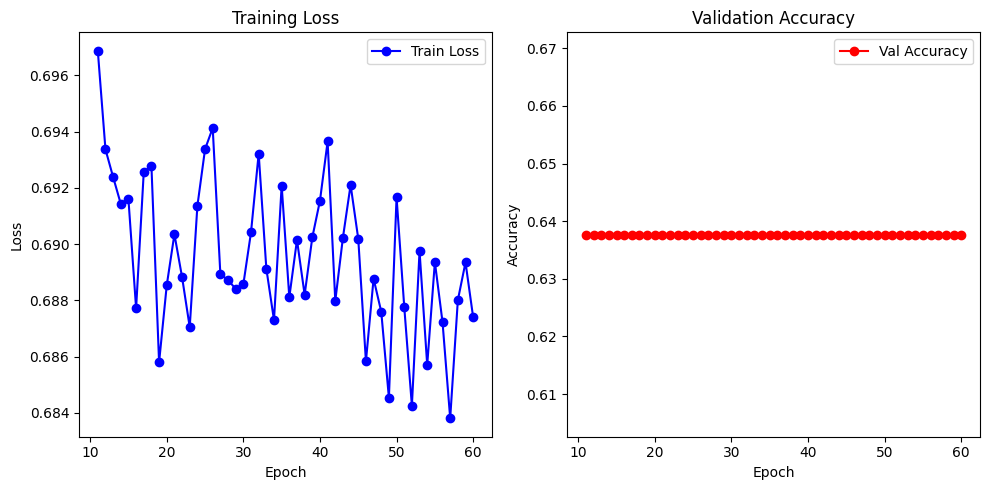

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(pre_epo + 1, epochs + 1), train_losses, 'b-o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(pre_epo + 1, epochs + 1), val_accs, 'r-o', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/train_val_plot.png')
plt.show()

## Step 8: Visualize Graph Structure
Extract and save the learned adjacency matrix for visualization in BrainNetViewer.

In [10]:
w_data = model.sigcnn.get_w_data().cpu().numpy()
np.savetxt('outputs/w_data.txt', w_data)
print('Adjacency matrix saved to outputs/w_data.txt for BrainNetViewer')

Adjacency matrix saved to outputs/w_data.txt for BrainNetViewer


## Step 9: Full Experiment (5 Runs × 5 Folds)
Run the full experiment to match the paper's evaluation (5 runs of 5-fold cross-validation).

In [11]:
for ind in range(5):
    setup_seed(ind)
    kf = KFold(n_splits=n_split, shuffle=True)
    kfold_index = 0
    for trainval_index, test_index in kf.split(X, Y):
        kfold_index += 1
        X_trainval, X_test = X[trainval_index], X[test_index]
        Y_trainval, Y_test = Y[trainval_index], Y[test_index]
        kf_inner = KFold(n_splits=n_split, shuffle=True)
        train_index, val_index = next(kf_inner.split(X_trainval, Y_trainval))
        X_train, X_val = X_trainval[train_index], X_trainval[val_index]
        Y_train, Y_val = Y_trainval[train_index], Y_trainval[val_index]

        model = Model(dropout=dropout, num_class=2)
        model.to(device)
        optimizer1 = optim.SGD(model.parameters(), lr=lr/5, weight_decay=decay, momentum=0.9, nesterov=True)
        optimizer2 = optim.SGD(model.parameters(), lr=lr, weight_decay=decay, momentum=0.9, nesterov=True)
        loss_fn = nn.CrossEntropyLoss()
        best_val_acc = 0
        best_model_path = f'outputs/model_seed{ind}_fold{kfold_index}.pth'

        for epoch in range(1, epochs + 1):
            model.train()
            idx_batch = np.random.permutation(int(X_train.shape[0]))
            num_batch = X_train.shape[0] // batch_size
            pre_num_batch = X_train.shape[0] // pre_batch
            loss_train = 0.0

            if epoch <= pre_epo:
                for bn in range(pre_num_batch):
                    batch = idx_batch[bn * pre_batch: (bn + 1) * pre_batch] if bn < pre_num_batch - 1 else idx_batch[bn * pre_batch:]
                    train_data_batch = X_train[batch]
                    train_data_batch_dev = torch.from_numpy(train_data_batch).float().to(device)
                    semi_loss = model(train_data_batch_dev, pre=True)
                    loss = sum(semi_loss)
                    optimizer1.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer1.step()
                    loss_train += loss.item()
                loss_train /= pre_num_batch
                print(f'Seed {ind}, Fold {kfold_index}, Epoch {epoch}, Pre-training loss: {loss_train:.4f}, Sparse rate: {(model.sigcnn.get_w_data() != 0).int().sum() / (116*116):.4f}')
            else:
                mini_net = nn.Sequential(model.sigcnn)
                for bn in range(num_batch):
                    batch = idx_batch[bn * batch_size: (bn + 1) * batch_size] if bn < num_batch - 1 else idx_batch[bn * batch_size:]
                    train_data_batch = X_train[batch]
                    train_label_batch = Y_train[batch]
                    train_data_batch_dev = torch.from_numpy(train_data_batch).float().to(device)
                    train_label_batch_dev = torch.from_numpy(train_label_batch).long().to(device)
                    model.eval()
                    with torch.no_grad():
                        train_data_batch_dev, _ = mini_net(train_data_batch_dev)
                    model.train()
                    outputs = model(train_data_batch_dev)
                    loss = loss_fn(outputs, train_label_batch_dev)
                    optimizer2.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer2.step()
                    loss_train += loss.item()
                loss_train /= num_batch

                model.eval()
                with torch.no_grad():
                    val_data_dev = torch.from_numpy(X_val).float().to(device)
                    val_label_dev = torch.from_numpy(Y_val).long().to(device)
                    val_data_dev, _ = mini_net(val_data_dev)
                    outputs = model(val_data_dev)
                    _, preds = torch.max(outputs, dim=1)
                    val_acc = metrics.accuracy_score(preds.cpu(), Y_val)
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        torch.save(model.state_dict(), best_model_path)
                if epoch % 10 == 0:
                    print(f'Seed {ind}, Fold {kfold_index}, Epoch {epoch}, Train loss: {loss_train:.4f}, Val acc: {val_acc:.4f}')

        model.load_state_dict(torch.load(best_model_path))
        model.eval()
        with torch.no_grad():
            test_data_dev = torch.from_numpy(X_test).float().to(device)
            test_data_dev, _ = mini_net(test_data_dev)
            outputs = model(test_data_dev)
            _, preds = torch.max(outputs, dim=1)
            acc, sen, spec, auc = confusion(Y_test, preds.cpu().numpy())
            print(f'Seed {ind}, Fold {kfold_index}, Test acc: {acc:.4f}, AUC: {auc:.4f}, Sensitivity: {sen:.4f}, Specificity: {spec:.4f}')
            result.append(acc)
            result_auc.append(auc)
            result_sen.append(sen)
            result_spec.append(spec)

# Final results
print(f'Final ACC: {np.mean(result):.4f}')
print(f'Final AUC: {np.mean(result_auc):.4f}')
print(f'Final Sensitivity: {np.mean(result_sen):.4f}')
print(f'Final Specificity: {np.mean(result_spec):.4f}')
np.save('outputs/results.npy', result)
np.save('outputs/aucs.npy', result_auc)
np.save('outputs/sens.npy', result_sen)
np.save('outputs/specs.npy', result_spec)

Seed 0, Fold 1, Epoch 1, Pre-training loss: 12.9906, Sparse rate: 0.7459
Seed 0, Fold 1, Epoch 2, Pre-training loss: 12.9425, Sparse rate: 0.7459
Seed 0, Fold 1, Epoch 3, Pre-training loss: 12.8806, Sparse rate: 0.7459
Seed 0, Fold 1, Epoch 4, Pre-training loss: 12.8269, Sparse rate: 0.7459
Seed 0, Fold 1, Epoch 5, Pre-training loss: 12.7833, Sparse rate: 0.7458
Seed 0, Fold 1, Epoch 6, Pre-training loss: 12.7446, Sparse rate: 0.7453
Seed 0, Fold 1, Epoch 7, Pre-training loss: 12.7069, Sparse rate: 0.7452
Seed 0, Fold 1, Epoch 8, Pre-training loss: 12.6700, Sparse rate: 0.7447
Seed 0, Fold 1, Epoch 9, Pre-training loss: 12.6376, Sparse rate: 0.7438
Seed 0, Fold 1, Epoch 10, Pre-training loss: 12.6014, Sparse rate: 0.7433
Seed 0, Fold 1, Epoch 20, Train loss: 0.6885, Val acc: 0.6377
Seed 0, Fold 1, Epoch 30, Train loss: 0.6886, Val acc: 0.6377
Seed 0, Fold 1, Epoch 40, Train loss: 0.6915, Val acc: 0.6377
Seed 0, Fold 1, Epoch 50, Train loss: 0.6917, Val acc: 0.6377
Seed 0, Fold 1, Epoch